# M/M/1 Queue Simulation

In [ ]:
import stochastix as stx
import jax
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', True)

plt.rcParams['font.size'] = 18

In [ ]:
from stochastix.kinetics import MassAction

# Rates 1/hour
lambda_1 = 10.0  # Arrival rate
lambda_3 = 10.0
mu_1 = jnp.array(1.0)  # Service rate of Q1
mu_2 = jnp.array(0.1)  # Service rate of Q2

network = stx.ReactionNetwork(
    [
        stx.Reaction('0 -> Q1', MassAction(k=lambda_1), name='Q1_arrival'),
        stx.Reaction(
            'Q1 -> Q2',
            MassAction(k=jnp.log(mu_1), transform=jnp.exp),
            name='Q1_to_Q2',
        ),
        stx.Reaction(
            '0 -> Q3',
            MassAction(k=jnp.log(lambda_3), transform=jnp.exp),
            name='Q3_arrival',
        ),
        stx.Reaction(
            'Q2 + Q3 -> P',
            MassAction(k=jnp.log(mu_2), transform=jnp.exp),
            name='Q2_departure',
        ),
    ]
)

T = 24.0

# Simulation of one day
model = stx.systems.StochasticModel(
    network, stx.DifferentiableDirect(), T=T, max_steps=2000
)

model_mf = stx.systems.MeanFieldModel(network, T=T, saveat_steps=50)

# initially empty system
x0 = jnp.array([0, 1, 3, 0])


# conveience funcs to recover rates from model
mu1_fn = lambda m: jnp.exp(m.network.Q1_to_Q2.kinetics.k)
mu2_fn = lambda m: jnp.exp(m.network.Q2_departure.kinetics.k)

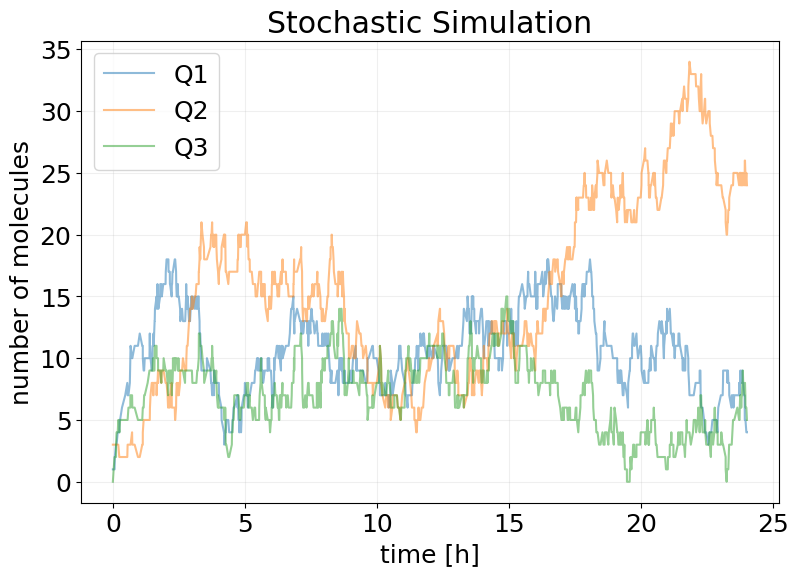

/Users/francesco/Documents/GitHub/jax-ssa/jax_ssa/_simulation_results.py:164: UserWarning: This object does not contain reaction information, returning original object.
  warnings.warn(


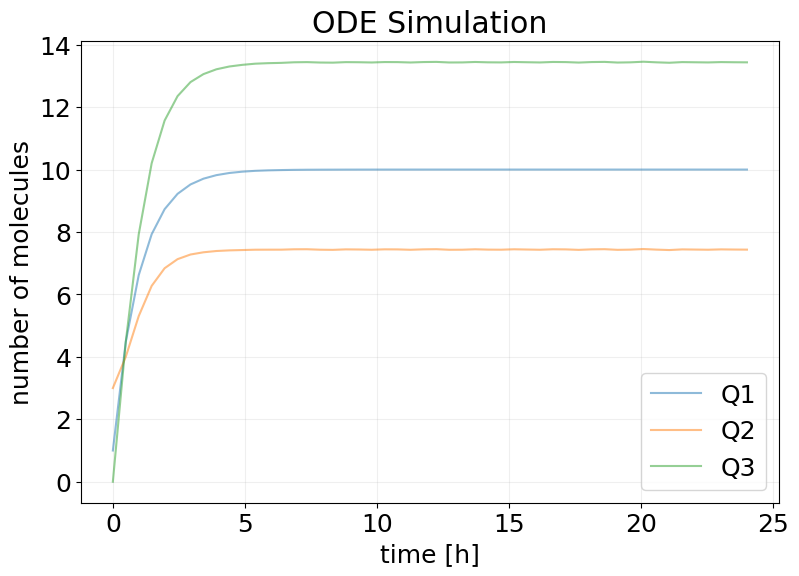

In [ ]:
key, subkey = jax.random.split(key)
sim_results = model(subkey, x0)

stx.plot_abundance_dynamic(
    sim_results, species=['Q1', 'Q2', 'Q3'], time_unit='h', base_time_unit='h'
)

plt.title('Stochastic Simulation')
plt.show()

mf_results = model_mf(subkey, x0)

stx.plot_abundance_dynamic(
    mf_results, species=['Q1', 'Q2', 'Q3'], time_unit='h', base_time_unit='h'
)

plt.title('ODE Simulation')
plt.show()

## Cost function

In [4]:
def generate_loss(cost_mu1=1.0, cost_mu2=1.0, holding_cost_rate=0.1):
    def _loss(model, x0, key):
        sim_results = model(key, x0)

        holding_cost = jnp.sum(sim_results.x[:-1, 1:], axis=1) * jnp.diff(sim_results.t)
        holding_cost = holding_cost_rate * jnp.sum(holding_cost**2) / model.T

        mu1 = model.network.Q1_to_Q2.kinetics.k
        mu1 = model.network.Q1_to_Q2.kinetics.transform(mu1)
        mu2 = model.network.Q2_departure.kinetics.k
        mu2 = model.network.Q2_departure.kinetics.transform(mu2)

        operational_cost_rate = (
            cost_mu1 * mu1 + cost_mu2 * mu2
        )  # * jax.lax.stop_gradient(model.T)

        return operational_cost_rate + holding_cost

    return _loss

## Training Function

In [5]:
import equinox as eqx
import optax
from tqdm import tqdm

In [6]:
def train(  # noqa
    key,
    model,
    x0,
    LOSS_FN,
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-3,
):
    # trick to vmap over named arguments
    loss_and_grads = eqx.filter_value_and_grad(LOSS_FN)
    loss_and_grads = eqx.filter_vmap(loss_and_grads, in_axes=(None, None, 0))

    losses = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        loss, grads = loss_and_grads(model, x0, subkeys)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss.mean()

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]

            pbar.set_description(f'Loss: {loss:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

    log = {'loss': losses}

    return model, log

## Optimize for fixed costs

### Stochastic

In [7]:
cost_mu1 = 30.0
cost_mu2 = 10.0
holding_cost_rate = 0.1

loss_fn = generate_loss(
    cost_mu1=cost_mu1, cost_mu2=cost_mu2, holding_cost_rate=holding_cost_rate
)

In [8]:
key, train_key = rng.split(key)

reparam_trained_model, log = train(
    train_key,
    model,
    x0,
    LOSS_FN=loss_fn,
    EPOCHS=500,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-2,
)

Loss: 24.29: 100%|██████████| 500/500 [00:55<00:00,  9.03it/s]


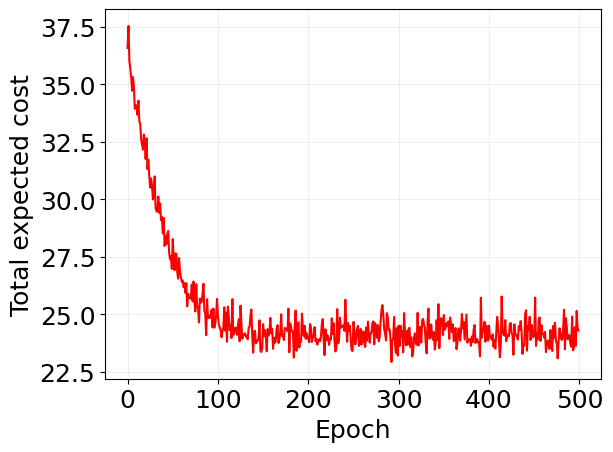

In [9]:
plt.plot(log['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Total expected cost')

plt.grid(alpha=0.2)

In [10]:
mu1 = mu1_fn(model)
mu2 = mu2_fn(model)

print(f'Initial mu1: {mu1:.2f}')
print(f'Initial mu2: {mu2:.2f}')
print('--------------------------------')

mu1_opt = mu1_fn(reparam_trained_model)
mu2_opt = mu2_fn(reparam_trained_model)

print(f'Final mu1: {mu1_opt:.2f}')
print(f'Final mu2: {mu2_opt:.2f}')

Initial mu1: 1.00
Initial mu2: 0.10
--------------------------------
Final mu1: 0.40
Final mu2: 0.21


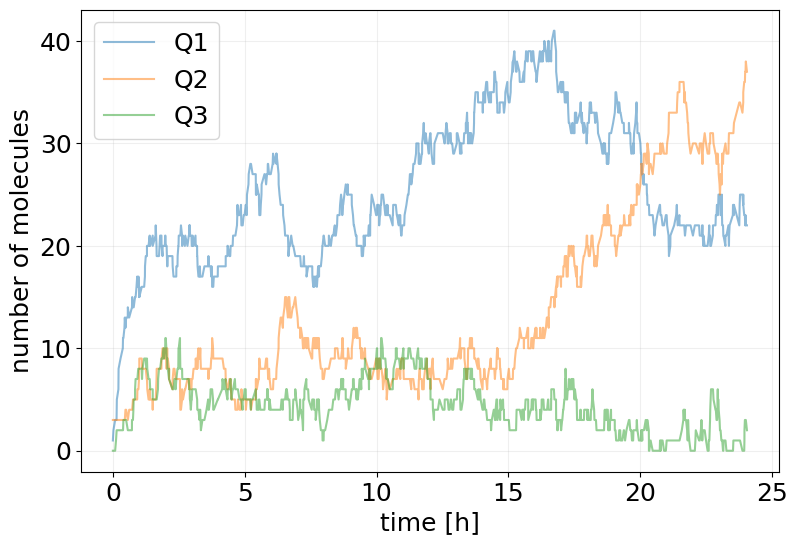

In [ ]:
key, subkey = jax.random.split(key)
sim_results_opt = reparam_trained_model(subkey, x0)

stx.plot_abundance_dynamic(
    sim_results_opt,
    species=['Q1', 'Q2', 'Q3'],
    time_unit='h',
    base_time_unit='h',
);

### Mean Field

In [12]:
key, train_key = rng.split(key)

mf_trained_model, log_mf = train(
    train_key,
    model_mf,
    x0,
    LOSS_FN=loss_fn,
    EPOCHS=500,
    BATCH_SIZE=1,
    LEARNING_RATE=1e-2,
)

Loss: 50.54: 100%|██████████| 500/500 [00:05<00:00, 94.51it/s] 


In [13]:
mu1 = mu1_fn(model)
mu2 = mu2_fn(model)

print(f'Initial mu1: {mu1:.2f}')
print(f'Initial mu2: {mu2:.2f}')
print('--------------------------------')

mu1_opt = mu1_fn(mf_trained_model)
mu2_opt = mu2_fn(mf_trained_model)

print(f'Final mu1: {mu1_opt:.2f}')
print(f'Final mu2: {mu2_opt:.2f}')

Initial mu1: 1.00
Initial mu2: 0.10
--------------------------------
Final mu1: 0.82
Final mu2: 0.65


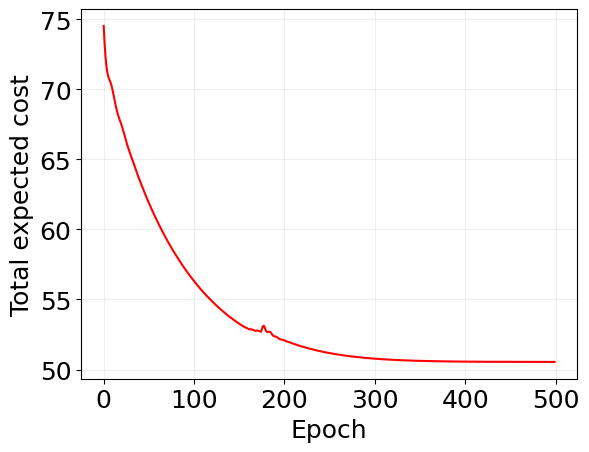

In [14]:
plt.plot(log_mf['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Total expected cost')

plt.grid(alpha=0.2)

In [ ]:
key, *cost_subkeys = jax.random.split(key, 1001)
cost_subkeys = jnp.array(cost_subkeys)

### Init
init_costs = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(model, x0, cost_subkeys)

### Opt Stoch
opt_costs = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(
    reparam_trained_model, x0, cost_subkeys
)

### Opt ODE
mf_to_stoch_model = stx.StochasticModel(
    mf_trained_model.network,
    stx.DirectMethod(),
    mf_trained_model.T,
    mf_trained_model.max_steps,
)
mf_opt_costs = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(
    mf_to_stoch_model, x0, cost_subkeys
)

In [16]:
init_costs.mean(), opt_costs.mean(), mf_opt_costs.mean()

(Array(36.95405479, dtype=float64),
 Array(24.06319699, dtype=float64),
 Array(35.31344221, dtype=float64))

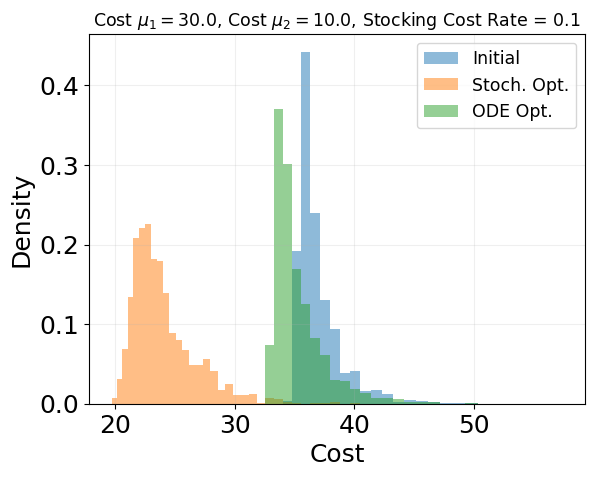

In [17]:
# Create logarithmic bins for better visualization of log-scale data
min_cost = min(jnp.min(init_costs), jnp.min(opt_costs), jnp.min(mf_opt_costs))
max_cost = max(jnp.max(init_costs), jnp.max(opt_costs), jnp.max(mf_opt_costs))
log_bins = jnp.logspace(jnp.log10(min_cost), jnp.log10(max_cost), 50)

plt.hist(init_costs, bins=log_bins, alpha=0.5, label='Initial', density=True)
plt.hist(opt_costs, bins=log_bins, alpha=0.5, label='Stoch. Opt.', density=True)
plt.hist(mf_opt_costs, bins=log_bins, alpha=0.5, label='ODE Opt.', density=True)

plt.grid(alpha=0.2)
plt.legend(fontsize='x-small')

plt.xlabel('Cost')
plt.ylabel('Density')

plt.title(
    f'Cost $\\mu_1 = {cost_mu1}$, Cost $\\mu_2 = {cost_mu2}$, Stocking Cost Rate = {holding_cost_rate}',
    fontsize='x-small',
)

plt.show()

## Scaling with holding cost

In [18]:
holding_costs = jnp.logspace(-4, 0, 10)

key, train_key = rng.split(key)

In [19]:
### STOCHASTIC SIMULATION
scaling_log = {
    'loss': jnp.zeros_like(holding_costs),
    'mu1': jnp.zeros_like(holding_costs),
    'mu2': jnp.zeros_like(holding_costs),
    'holding_cost': holding_costs,
}


loss_per_cost = []
for i, holding_cost in enumerate(holding_costs):
    loss_fn = generate_loss(
        cost_mu1=10.0, cost_mu2=100.0, holding_cost_rate=holding_cost
    )

    trained_model, log = train(
        train_key,
        model,
        x0,
        LOSS_FN=loss_fn,
        EPOCHS=500,
        BATCH_SIZE=32,
        LEARNING_RATE=1e-2,
    )

    loss_per_cost.append(log['loss'])

    scaling_log['loss'] = scaling_log['loss'].at[i].set(log['loss'][-1])
    scaling_log['mu1'] = scaling_log['mu1'].at[i].set(mu1_fn(trained_model))
    scaling_log['mu2'] = scaling_log['mu2'].at[i].set(mu2_fn(trained_model))

Loss: 79.87: 100%|██████████| 500/500 [00:53<00:00,  9.31it/s]


In [20]:
### ODE SIMULATION
mf_scaling_log = {
    'loss': jnp.zeros_like(holding_costs),
    'mu1': jnp.zeros_like(holding_costs),
    'mu2': jnp.zeros_like(holding_costs),
    'holding_cost': holding_costs,
}


mf_loss_per_cost = []
for i, holding_cost in enumerate(holding_costs):
    loss_fn = generate_loss(
        cost_mu1=10.0, cost_mu2=100.0, holding_cost_rate=holding_cost
    )

    trained_model, log = train(
        train_key,
        model_mf,
        x0,
        LOSS_FN=loss_fn,
        EPOCHS=350,
        BATCH_SIZE=32,
        LEARNING_RATE=1e-2,
    )

    mf_loss_per_cost.append(log['loss'])

    mf_scaling_log['loss'] = mf_scaling_log['loss'].at[i].set(log['loss'][-1])
    mf_scaling_log['mu1'] = mf_scaling_log['mu1'].at[i].set(mu1_fn(trained_model))
    mf_scaling_log['mu2'] = mf_scaling_log['mu2'].at[i].set(mu2_fn(trained_model))

Loss: 151.92: 100%|██████████| 350/350 [00:02<00:00, 151.78it/s]


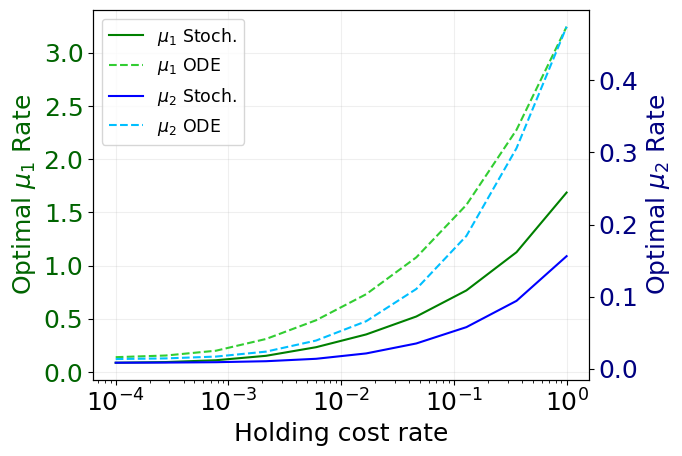

In [26]:
fig, ax1 = plt.subplots()

# Plot mu1 on left y-axis
ax1.plot(scaling_log['holding_cost'], scaling_log['mu1'], 'g', label='$\\mu_1$ Stoch.')
ax1.plot(
    mf_scaling_log['holding_cost'],
    mf_scaling_log['mu1'],
    'limegreen',
    linestyle='--',
    label='$\\mu_1$ ODE',
)
ax1.set_xscale('log')
ax1.set_xlabel('Holding cost rate')
ax1.set_ylabel('Optimal $\\mu_1$ Rate', color='darkgreen')
ax1.tick_params(axis='y', labelcolor='darkgreen')
ax1.grid(alpha=0.2)

# Create second y-axis for mu2
ax2 = ax1.twinx()
ax2.plot(scaling_log['holding_cost'], scaling_log['mu2'], 'b', label='$\\mu_2$ Stoch.')
ax2.plot(
    mf_scaling_log['holding_cost'],
    mf_scaling_log['mu2'],
    'deepskyblue',
    linestyle='--',
    label='$\\mu_2$ ODE',
)
ax2.set_ylabel('Optimal $\\mu_2$ Rate', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

# Add common legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize='x-small')

Text(0, 0.5, 'Optimal expected cost')

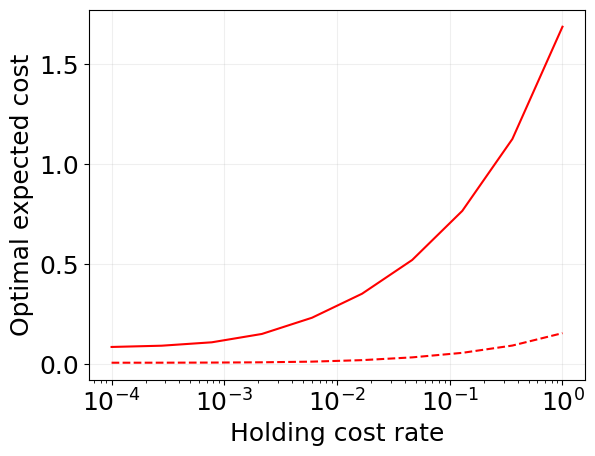

In [22]:
plt.plot(scaling_log['holding_cost'], scaling_log['mu1'], 'r')
plt.plot(scaling_log['holding_cost'], scaling_log['mu2'], 'r--')

plt.xscale('log')
# plt.yscale('log')

plt.grid(alpha=0.2)
plt.xlabel('Holding cost rate')
plt.ylabel('Optimal expected cost')

Text(0, 0.5, 'Normalized Loss')

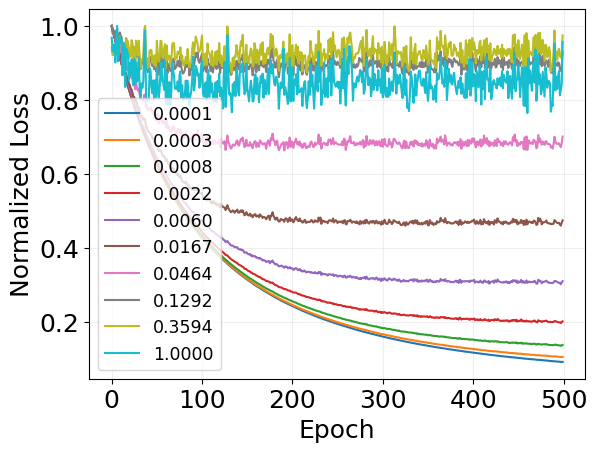

In [23]:
for i, losses in enumerate(loss_per_cost):
    plt.plot(
        jnp.array(losses) / max(losses),
        label=f'{scaling_log["holding_cost"][i]:.4f}',
    )

plt.legend(fontsize='x-small')

plt.grid(alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')

Text(0, 0.5, 'Normalized Loss')

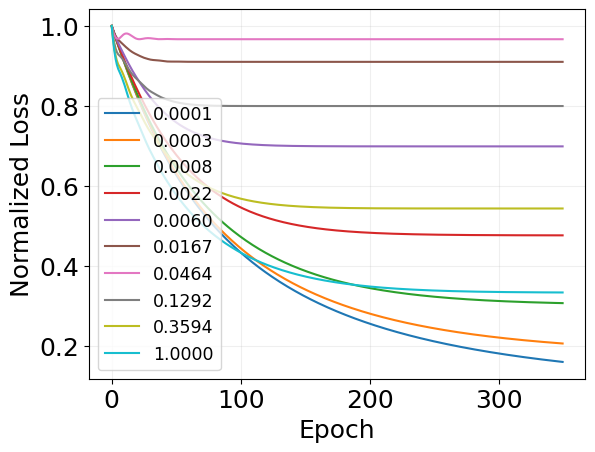

In [25]:
for i, losses in enumerate(mf_loss_per_cost):
    plt.plot(
        jnp.array(losses) / max(losses),
        label=f'{mf_scaling_log["holding_cost"][i]:.4f}',
    )

plt.legend(fontsize='x-small')

plt.grid(alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')